<!-- # TF-IDF + ML Article Classification for OSE

🎯 **Objectives**:
* Process French articles using TF-IDF vectorization + Traditional ML models
* Classify articles into signal types (4 positive, 4 negative)
* Generate article-level predictions for aggregation -->


<!-- ## (1) Setup & Configuration -->


In [7]:
# 1 - DATA MANIPULATION
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 100)
from pathlib import Path
import ast
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# 2 - DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# 3 - MACHINE LEARNING
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# SHAP library for model explainability

import shap
shap.initjs()

# Configuration
RANDOM_SEED = 42
DATA_DIR = Path("../src/ose_core/data/extracted_datasets")

np.random.seed(RANDOM_SEED)

print("Imports successful")
print("Using TF-IDF + Traditional ML approach")


Imports successful
Using TF-IDF + Traditional ML approach


<!-- ## (2) Data Loading & Preparation -->


In [8]:
# # Load articles dataset
df = pd.read_csv(
    DATA_DIR / "09_articles.csv",
    dtype={'siren': str, 'siret': str})

df.sample(5)


,company_name,siren,siret,title,publishedAt,author,signalsStatus,signalsType,country,sectors,cities,sources,all_companies_count
210,BOCAGE RESTAURATION,337703334,33770333400058,Bocage Restauration veut construire une nouvelle usine,2018-05-02T00:00:00+02:00,"{'initial': 'A.G', 'name': 'Aurélie GALBOIS', 'id': 58}","[{'label': 'Détecté'}, {'label': 'Détecté'}, {'label': 'Détecté'}]","[{'label': 'Construction'}, {'label': 'Déménagement'}, {'label': 'Restructuration, Réorganisatio...","{'id': 72, 'label': 'France'}","{'logo': 'Agroalimentaire180.png', 'industry': True, 'id': 3, 'label': 'AGROALIMENTAIRE', 'paren...","{'zipCode': '69630', 'code': '69043', 'latitude': '45.7090613641', 'id': 69043, 'label': 'Chapon...","{'author': 'Baptiste BIZE', 'datePub': '25/04/2018', 'urlWeb': 'http://www.centre-presse.fr', 'i...",2
58,ESPINET,311461982,31146198200036,La société Espinet prévoit d'agrandir son site à Carsac Aillac et de moderniser son outil de pro...,2018-07-26T00:00:00+02:00,"{'initial': 'A.R', 'name': 'Alix RODRIGUE', 'id': 65}","[{'label': 'Détecté'}, {'label': 'Détecté'}, {'label': 'Détecté'}]","[{'label': 'Investissements'}, {'label': 'Construction'}, {'label': 'Levée de fonds, financement...","{'id': 72, 'label': 'France'}","{'logo': 'Agroalimentaire180.png', 'industry': True, 'id': 3, 'label': 'AGROALIMENTAIRE', 'paren...","{'zipCode': '24330', 'code': '24053', 'latitude': '45.1421175018', 'id': 24053, 'label': 'Boulaz...","{'urlWeb': 'https://www.decidento.com/', 'id': 640, 'typeSource': 4, 'label': 'DELIBERATIONS et ...",2
943,BISCUITERIE MISTRAL,542003629,54200362900020,La Biscuiterie Mistral souhaite se déployer au niveau national,2022-06-24T00:00:00+02:00,"{'initial': 'M.L', 'name': 'Mathieu Lallement', 'id': 22}",[{'label': 'Détecté'}],"[{'label': ""Développement de l'activité""}]","{'id': 72, 'label': 'France'}","{'logo': 'Agroalimentaire180.png', 'industry': True, 'id': 3, 'label': 'AGROALIMENTAIRE', 'paren...","{'zipCode': '21140', 'code': '21603', 'latitude': '47.4910013993', 'id': 21603, 'label': 'Semur-...","{'author': 'E. Tauveron', 'datePub': '18/06/2022', 'urlWeb': 'http://www.bienpublic.com', 'id': ...",1
584,OCEAN DE PAINS,453762387,45376238700018,Les boulangeries Lucas souhaitent ouvrir de nouveaux sites et envisagent un déménagement de l'at...,2025-05-21T00:00:00+02:00,"{'initial': 'A.S', 'name': 'Ashanti Salmon', 'id': 121}","[{'label': 'Détecté'}, {'label': 'Détecté'}]","[{'label': 'Création & ouverture'}, {'label': 'Déménagement'}]","{'id': 72, 'label': 'France'}","{'logo': 'Agroalimentaire180.png', 'industry': True, 'id': 3, 'label': 'AGROALIMENTAIRE', 'paren...","{'zipCode': '40480', 'code': '40328', 'latitude': '43.787487317', 'id': 40328, 'label': 'Vieux-B...","{'author': 'C. Cordeiro', 'datePub': '14/05/2025', 'urlWeb': 'http://www.sudouest.fr', 'id': 134...",2
218,MAISON BERTEL,338483159,33848315900012,Projet de complexe sportif à Mâcon,2014-03-20T00:00:00+01:00,"{'initial': 'S.R', 'name': 'Soizic RIGAL', 'id': 14}",[{'label': 'Détecté'}],[{'label': 'Construction'}],"{'id': 72, 'label': 'France'}","{'logo': 'Agroalimentaire180.png', 'industry': True, 'id': 3, 'label': 'AGROALIMENTAIRE', 'paren...",NaN,"{'author': 'L. Bollet', 'datePub': '19/03/14', 'urlWeb': 'http://www.lejsl.com/economie', 'id': ...",1


In [9]:
# Number of articles per company
df_articles_per_company = (
    df.groupby(['company_name', 'siren', 'siret'])
    .size()
    .reset_index(name='article_count')
    .sort_values('article_count', ascending=False)
    .reset_index(drop=True)
)

df_articles_per_company

,company_name,siren,siret,article_count
0,FERMENTALG,509935151,50993515100019,83
1,YNSECT,534948617,53494861700046,60
2,SILL ENTREPRISES,636220220,63622022000017,45
3,GRAIN DE SAIL,538866740,53886674000011,32
4,COFIGEO,542076633,54207663300131,27
...,...,...,...,...
261,PIERRE OTEIZA,530671031,53067103100017,1
262,HUITRES LAMBERT,314841164,31484116400028,1
263,JEDA,449061860,44906186000044,1
264,L'ALBIGEOISE DE PATONS,340409713,34040971300062,1


<!-- ## (3) Signal Definitions -->


In [10]:
# Define signal categories aligned with business_opportunity_classifier
POSITIVE_SIGNALS = [
    "Investissements",
    "Recrutement",
    "Construction",
    "Levée de fonds, financements & modifs. capital"
]

NEGATIVE_SIGNALS = [
    "Vente & Cession",
    "RJ & LJ",
    "Restructuration, Réorganisation",
    "Licenciement & chômage"
]

ALL_SIGNALS = POSITIVE_SIGNALS + NEGATIVE_SIGNALS

pd.DataFrame({
    'Type': ['Positive'] * len(POSITIVE_SIGNALS) + ['Negative'] * len(NEGATIVE_SIGNALS),
    'Signal': POSITIVE_SIGNALS + NEGATIVE_SIGNALS
})


,Type,Signal
0,Positive,Investissements
1,Positive,Recrutement
2,Positive,Construction
3,Positive,"Levée de fonds, financements & modifs. capital"
4,Negative,Vente & Cession
5,Negative,RJ & LJ
6,Negative,"Restructuration, Réorganisation"
7,Negative,Licenciement & chômage


<!-- ## (4) Text Preprocessing -->


In [11]:
def preprocess_text(text):
    """Preprocess text for TF-IDF vectorization."""
    if pd.isna(text) or not isinstance(text, str):
        return ""
    return text.strip()

df["title_processed"] = df["title"].apply(preprocess_text)


<!-- ## (5) Extract Signal Labels -->


In [12]:
def extract_signal_labels(signals_str):
    """Extract signal labels from the signalsType column."""
    if pd.isna(signals_str):
        return []
    try:
        signals_list = ast.literal_eval(signals_str)
        if isinstance(signals_list, list):
            return [s['label'] for s in signals_list if isinstance(s, dict) and 'label' in s]
    except:
        pass
    return []

df["signal_labels"] = df["signalsType"].apply(extract_signal_labels)

def get_signal_col_name(signal):
    """Generate column name for signal."""
    return f"has_{signal.lower().replace(' ', '_').replace('&', 'et').replace(',', '')}"

for signal in ALL_SIGNALS:
    df[get_signal_col_name(signal)] = df["signal_labels"].apply(lambda labels: 1 if signal in labels else 0)

# Signal label counts
pd.DataFrame({
    'Signal': ALL_SIGNALS,
    'Count': [df[get_signal_col_name(s)].sum() for s in ALL_SIGNALS]
})


,Signal,Count
0,Investissements,292
1,Recrutement,259
2,Construction,395
3,"Levée de fonds, financements & modifs. capital",242
4,Vente & Cession,155
5,RJ & LJ,29
6,"Restructuration, Réorganisation",34
7,Licenciement & chômage,42


In [13]:
# Filter articles that have at least one target signal
signal_cols = [get_signal_col_name(signal) for signal in ALL_SIGNALS]
df["has_target_signal"] = df[signal_cols].sum(axis=1) > 0

df_classify = df[df["has_target_signal"] == True].copy()


<!-- ## (6) Model Training Setup -->


In [14]:
# TF-IDF Vectorizer Configuration
# Each signal will have its own vectorizer fitted on its training data
# Parameters:
# - max_features=10000: Limit vocabulary size
# - ngram_range=(1, 2): Unigrams and bigrams
# - min_df=2: Minimum document frequency
# - max_df=0.95: Maximum document frequency (remove very common words)

print("TF-IDF + ML approach ready")
print("Each signal will be trained with its own TF-IDF vectorizer and Logistic Regression model")


TF-IDF + ML approach ready
Each signal will be trained with its own TF-IDF vectorizer and Logistic Regression model


<!-- ## (7) Model Training -->


In [15]:
# Train a model for each signal type
results = {}

for signal in ALL_SIGNALS:
    print(f"\n{'='*60}")
    print(f"Training model for: {signal}")
    print('='*60)

    col_name = get_signal_col_name(signal)
    y = df_classify[col_name].values

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        df_classify["title_processed"].values,
        y,
        test_size=0.2,
        random_state=RANDOM_SEED,
        stratify=y
    )

    print(f"Train: {len(X_train)}, Test: {len(X_test)}")
    print(f"Positive examples: {y.sum()} ({y.sum()/len(y)*100:.1f}%)")

    # Create and fit TF-IDF vectorizer on training data for this signal
    signal_vectorizer = TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        lowercase=True,
        strip_accents='unicode'
    )
    X_train_tfidf = signal_vectorizer.fit_transform(X_train)
    X_test_tfidf = signal_vectorizer.transform(X_test)

    print(f"TF-IDF features shape: {X_train_tfidf.shape}")

    # Train Logistic Regression model
    model = LogisticRegression(
        random_state=RANDOM_SEED,
        max_iter=1000,
        class_weight='balanced'  # Handle class imbalance
    )

    model.fit(X_train_tfidf, y_train)

    # Evaluate
    y_pred = model.predict(X_test_tfidf)
    accuracy = (y_pred == y_test).mean()

    # Store results (including TF-IDF matrices for SHAP explainability)
    # Use a sample of the training data as SHAP background to keep computations reasonable
    if X_train_tfidf.shape[0] > 500:
        X_train_background = X_train_tfidf[:500]
    else:
        X_train_background = X_train_tfidf

    if X_test_tfidf.shape[0] > 200:
        X_test_shap_subset = X_test_tfidf[:200]
        X_test_text_subset = X_test[:200]
    else:
        X_test_shap_subset = X_test_tfidf
        X_test_text_subset = X_test

    results[signal] = {
        'model': model,
        'vectorizer': signal_vectorizer,
        'y_test': y_test,
        'y_pred': y_pred,
        'accuracy': accuracy,
        'X_test': X_test,
        'X_train_background': X_train_background,
        'X_test_shap_subset': X_test_shap_subset,
        'X_test_text_subset': X_test_text_subset
    }

    print(f"Completed training for {signal}")
    print(f"Accuracy: {accuracy:.3f}")

print(f"\nTrained {len(results)} TF-IDF + ML models")



Training model for: Investissements
Train: 751, Test: 188
Positive examples: 292 (31.1%)
TF-IDF features shape: (751, 1499)
Completed training for Investissements
Accuracy: 0.824

Training model for: Recrutement
Train: 751, Test: 188
Positive examples: 259 (27.6%)
TF-IDF features shape: (751, 1500)
Completed training for Recrutement
Accuracy: 0.787

Training model for: Construction
Train: 751, Test: 188
Positive examples: 395 (42.1%)
TF-IDF features shape: (751, 1513)
Completed training for Construction
Accuracy: 0.814

Training model for: Levée de fonds, financements & modifs. capital
Train: 751, Test: 188
Positive examples: 242 (25.8%)
TF-IDF features shape: (751, 1500)
Completed training for Levée de fonds, financements & modifs. capital
Accuracy: 0.814

Training model for: Vente & Cession
Train: 751, Test: 188
Positive examples: 155 (16.5%)
TF-IDF features shape: (751, 1533)
Completed training for Vente & Cession
Accuracy: 0.936

Training model for: RJ & LJ
Train: 751, Test: 188
P

<!-- ## (8) Model Evaluation -->


<!-- ## (10) SHAP Explainability - Global Feature Importance -->


In [16]:
# Create SHAP explainers and compute global SHAP values for each signal
shap_explainers = {}
shap_global_importance = {}

for signal in ALL_SIGNALS:
    result = results[signal]
    model = result['model']
    background = result['X_train_background']
    X_test_subset = result['X_test_shap_subset']

    explainer = shap.LinearExplainer(model, background)
    shap_values = explainer.shap_values(X_test_subset)

    # For binary classification with scikit-learn LogisticRegression, shap_values may be:
    # - a list [shap_class0, shap_class1]
    # - or a single array (n_samples, n_features)
    if isinstance(shap_values, list):
        # Focus on the positive class (index 1) if available
        shap_values_array = shap_values[1] if len(shap_values) > 1 else shap_values[0]
    else:
        shap_values_array = shap_values

    shap_explainers[signal] = explainer
    shap_global_importance[signal] = shap_values_array

    # Store in results for later reuse (e.g., local explanations)
    results[signal]['shap_explainer'] = explainer
    results[signal]['shap_values_global'] = shap_values_array



In [17]:
# Build DataFrame summaries of global SHAP feature importance for each signal
shap_importance_dfs = {}

for signal in ALL_SIGNALS:
    shap_values_array = shap_global_importance[signal]
    vectorizer = results[signal]['vectorizer']
    feature_names = np.array(vectorizer.get_feature_names_out())

    mean_abs_shap = np.abs(shap_values_array).mean(axis=0)

    df_importance = (
        pd.DataFrame({
            'feature': feature_names,
            'mean_abs_shap': mean_abs_shap
        })
        .sort_values('mean_abs_shap', ascending=False)
        .reset_index(drop=True)
    )

    shap_importance_dfs[signal] = df_importance
    results[signal]['shap_importance_df'] = df_importance

# Concatenated view of top features per signal (e.g., top 20)
TOP_N_FEATURES = 20

df_shap_global_top = pd.concat([
    df.assign(Signal=signal).iloc[:TOP_N_FEATURES]
    for signal, df in shap_importance_dfs.items()
], ignore_index=True)[['Signal', 'feature', 'mean_abs_shap']]

df_shap_global_top


,Signal,feature,mean_abs_shap
0,Investissements,investit,0.187266
1,Investissements,investissements,0.100352
2,Investissements,et,0.067580
3,Investissements,ynsect,0.066760
4,Investissements,investir,0.053054
...,...,...,...
155,Licenciement & chômage,recrute,0.017430
156,Licenciement & chômage,des,0.016465
157,Licenciement & chômage,projet,0.016036
158,Licenciement & chômage,sill,0.014416


<!-- ## (11) SHAP Explainability - Visualizations -->


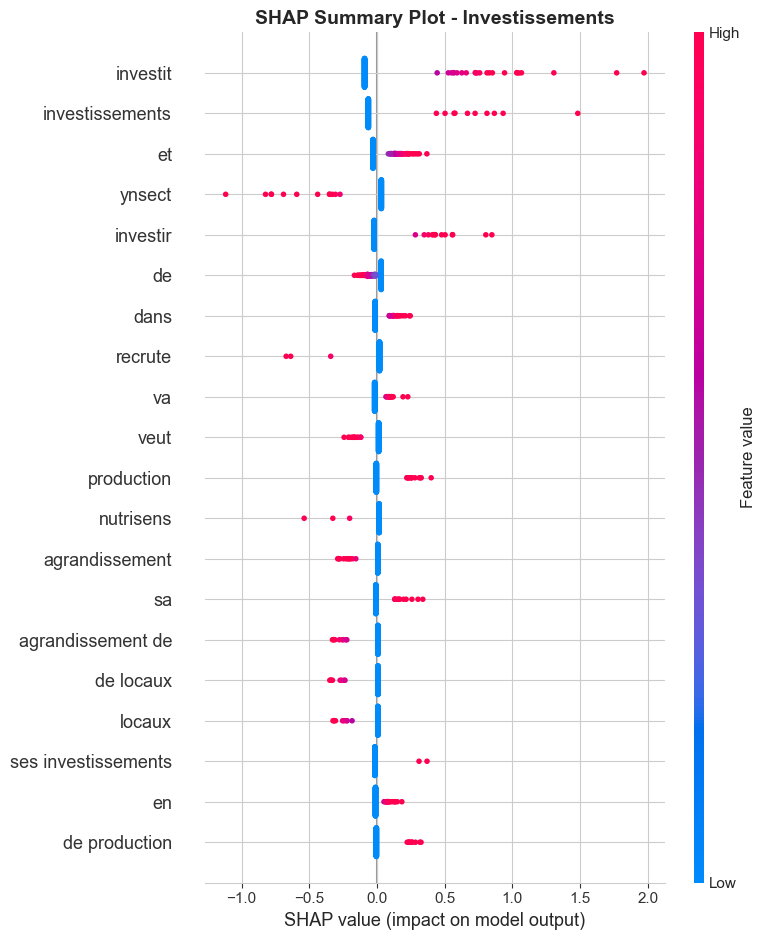

In [18]:
# Global SHAP Summary Plot for one signal
# Change the signal name below to visualize a different signal
signal = "Investissements"

explainer = shap_explainers[signal]
X_test_subset = results[signal]['X_test_shap_subset']
feature_names = results[signal]['vectorizer'].get_feature_names_out()

# Create SHAP Explanation object and extract raw values for proper color coding
shap_explanation = explainer(X_test_subset)
shap_values_array = shap_explanation.values
X_test_dense = X_test_subset.toarray()

# Global summary plot showing feature importance with color coding
shap.summary_plot(shap_values_array, X_test_dense, feature_names=feature_names, max_display=20, show=False)
plt.title(f'SHAP Summary Plot - {signal}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Article text: Mulot et Petitjean veut s'agrandir

Signal: Investissements
Article index in test subset: 0



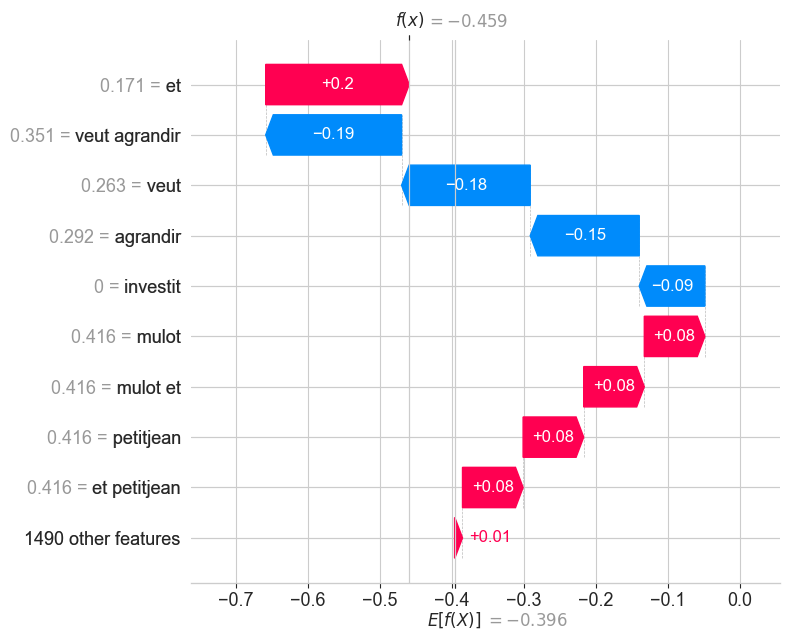

In [19]:
# Local SHAP Waterfall Plot for a single test article
# Change the signal name and article_index below to explore different articles
signal = "Investissements"
article_index = 0  # Index in the test subset (0 to len(X_test_shap_subset)-1)

explainer = shap_explainers[signal]
X_test_subset = results[signal]['X_test_shap_subset']
texts = results[signal]['X_test_text_subset']
feature_names = results[signal]['vectorizer'].get_feature_names_out()

# Get SHAP values for this specific article
shap_explanation = explainer(X_test_subset[article_index:article_index+1])

# Extract base value (handle both scalar and array cases)
base_val = shap_explanation.base_values
if isinstance(base_val, (list, np.ndarray)) and len(base_val) > 0:
    base_val = base_val[0] if len(base_val) > 0 else base_val

# Create Explanation object with feature names for proper display
shap_values_with_names = shap.Explanation(
    values=shap_explanation.values[0],
    base_values=base_val,
    data=X_test_subset[article_index:article_index+1].toarray()[0],
    feature_names=feature_names
)

# Display the article text
print(f"Article text: {texts[article_index]}")
print(f"\nSignal: {signal}")
print(f"Article index in test subset: {article_index}\n")

# Waterfall plot showing how each feature contributes to the prediction
shap.waterfall_plot(shap_values_with_names, show=False)
plt.tight_layout()
plt.show()


Article text: Mulot et Petitjean veut s'agrandir

Signal: Investissements
Article index in test subset: 0



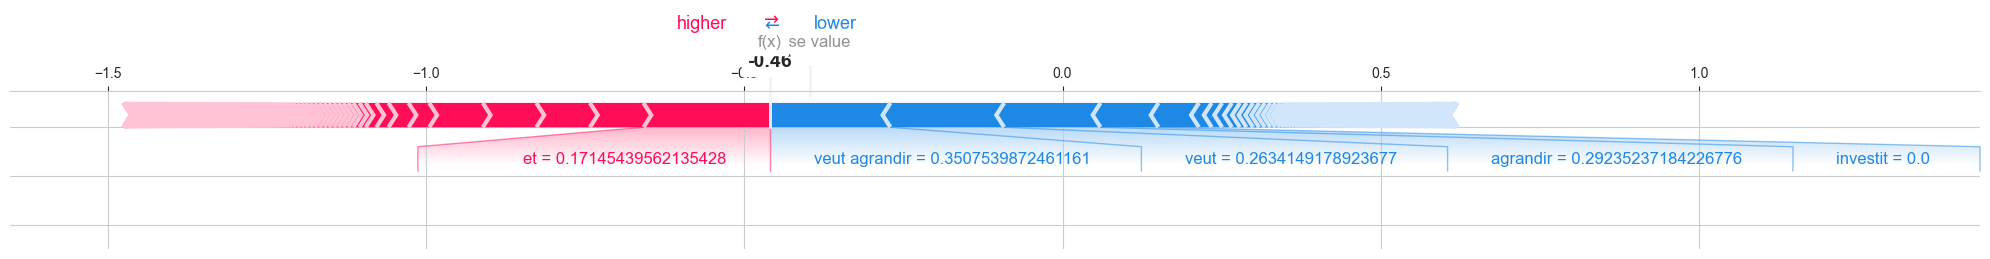

In [20]:
# Local SHAP Force Plot for a single test article
# Change the signal name and article_index below to explore different articles
signal = "Investissements"
article_index = 0  # Index in the test subset (0 to len(X_test_shap_subset)-1)

explainer = shap_explainers[signal]
X_test_subset = results[signal]['X_test_shap_subset']
texts = results[signal]['X_test_text_subset']
feature_names = results[signal]['vectorizer'].get_feature_names_out()

# Get SHAP values for this specific article
shap_explanation = explainer(X_test_subset[article_index:article_index+1])

# Extract base value (handle both scalar and array cases)
base_val = shap_explanation.base_values
if isinstance(base_val, (list, np.ndarray)) and len(base_val) > 0:
    base_val = base_val[0] if len(base_val) > 0 else base_val

# Create Explanation object with feature names for proper display
shap_values_with_names = shap.Explanation(
    values=shap_explanation.values[0],
    base_values=base_val,
    data=X_test_subset[article_index:article_index+1].toarray()[0],
    feature_names=feature_names
)

# Display the article text
print(f"Article text: {texts[article_index]}")
print(f"\nSignal: {signal}")
print(f"Article index in test subset: {article_index}\n")

# Force plot showing how each feature contributes to the prediction
# Note: force_plot returns HTML, so we use shap.plots.force for notebook display
shap.plots.force(shap_values_with_names, matplotlib=True, show=False)
plt.tight_layout()
plt.show()


In [21]:
# DataFrame summary of top contributing features for a specific article
# Change the signal name and article_index below to explore different articles
signal = "Investissements"
article_index = 0  # Index in the test subset
top_n = 20  # Number of top features to display

explainer = shap_explainers[signal]
X_test_subset = results[signal]['X_test_shap_subset']
texts = results[signal]['X_test_text_subset']
feature_names = results[signal]['vectorizer'].get_feature_names_out()

# Get SHAP values for this specific article
shap_values = explainer(X_test_subset[article_index:article_index+1])

# Extract SHAP values array
if hasattr(shap_values, 'values'):
    shap_array = shap_values.values[0]
else:
    shap_array = np.asarray(shap_values[0]).flatten()

# Get non-zero features (features that appear in this article)
X_example = X_test_subset[article_index:article_index+1]
nonzero_indices = X_example.nonzero()[1]

# Create DataFrame with top contributing features
df_local_shap = (
    pd.DataFrame({
        'feature': feature_names[nonzero_indices],
        'shap_value': shap_array[nonzero_indices]
    })
    .sort_values('shap_value', ascending=False, key=abs)
    .head(top_n)
    .reset_index(drop=True)
)

print(f"Article: {texts[article_index]}")
print(f"Signal: {signal}\n")
df_local_shap


Article: Mulot et Petitjean veut s'agrandir
Signal: Investissements



,feature,shap_value
0,et,0.199289
1,veut agrandir,-0.188701
2,veut,-0.178652
3,agrandir,-0.151378
4,et petitjean,0.084150
5,mulot,0.084150
6,mulot et,0.084150
7,petitjean,0.084150


In [22]:
# Evaluate each model and store results in DataFrame
from sklearn.metrics import precision_recall_fscore_support

df_metrics_summary = pd.DataFrame([
    {
        'Signal': signal,
        'Accuracy': (result['y_pred'] == result['y_test']).mean(),
        'Precision_Neg': precision[0],
        'Recall_Neg': recall[0],
        'F1_Neg': f1[0],
        'Support_Neg': support[0],
        'Precision_Pos': precision[1],
        'Recall_Pos': recall[1],
        'F1_Pos': f1[1],
        'Support_Pos': support[1]
    }
    for signal, result in results.items()
    for precision, recall, f1, support in [precision_recall_fscore_support(
        result['y_test'], result['y_pred'], zero_division=0
    )]
])

df_metrics_summary


,Signal,Accuracy,Precision_Neg,Recall_Neg,F1_Neg,Support_Neg,Precision_Pos,Recall_Pos,F1_Pos,Support_Pos
0,Investissements,0.824468,0.881890,0.861538,0.871595,130,0.704918,0.741379,0.722689,58
1,Recrutement,0.787234,0.875000,0.823529,0.848485,136,0.600000,0.692308,0.642857,52
2,Construction,0.813830,0.813559,0.880734,0.845815,109,0.814286,0.721519,0.765101,79
3,"Levée de fonds, financements & modifs. capital",0.813830,0.888889,0.857143,0.872727,140,0.622642,0.687500,0.653465,48
4,Vente & Cession,0.936170,0.961783,0.961783,0.961783,157,0.806452,0.806452,0.806452,31
5,RJ & LJ,0.968085,0.978261,0.989011,0.983607,182,0.500000,0.333333,0.400000,6
6,"Restructuration, Réorganisation",0.909574,0.960674,0.944751,0.952646,181,0.000000,0.000000,0.000000,7
7,Licenciement & chômage,0.962766,0.977901,0.983333,0.980609,180,0.571429,0.500000,0.533333,8


In [23]:
# Store confusion matrices in DataFrame
df_confusion_matrices = pd.DataFrame([
    {
        'Signal': signal,
        'True Negative': tn,
        'False Positive': fp,
        'False Negative': fn,
        'True Positive': tp,
        'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'Sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'Precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'Recall': tp / (tp + fn) if (tp + fn) > 0 else 0
    }
    for signal, result in results.items()
    for tn, fp, fn, tp in [confusion_matrix(result['y_test'], result['y_pred']).ravel()]
])

df_confusion_matrices


,Signal,True Negative,False Positive,False Negative,True Positive,Specificity,Sensitivity,Precision,Recall
0,Investissements,112,18,15,43,0.861538,0.741379,0.704918,0.741379
1,Recrutement,112,24,16,36,0.823529,0.692308,0.600000,0.692308
2,Construction,96,13,22,57,0.880734,0.721519,0.814286,0.721519
3,"Levée de fonds, financements & modifs. capital",120,20,15,33,0.857143,0.687500,0.622642,0.687500
4,Vente & Cession,151,6,6,25,0.961783,0.806452,0.806452,0.806452
5,RJ & LJ,180,2,4,2,0.989011,0.333333,0.500000,0.333333
6,"Restructuration, Réorganisation",171,10,7,0,0.944751,0.000000,0.000000,0.000000
7,Licenciement & chômage,177,3,4,4,0.983333,0.500000,0.571429,0.500000


<!-- ## (9) Confusion Matrix Visualizations -->


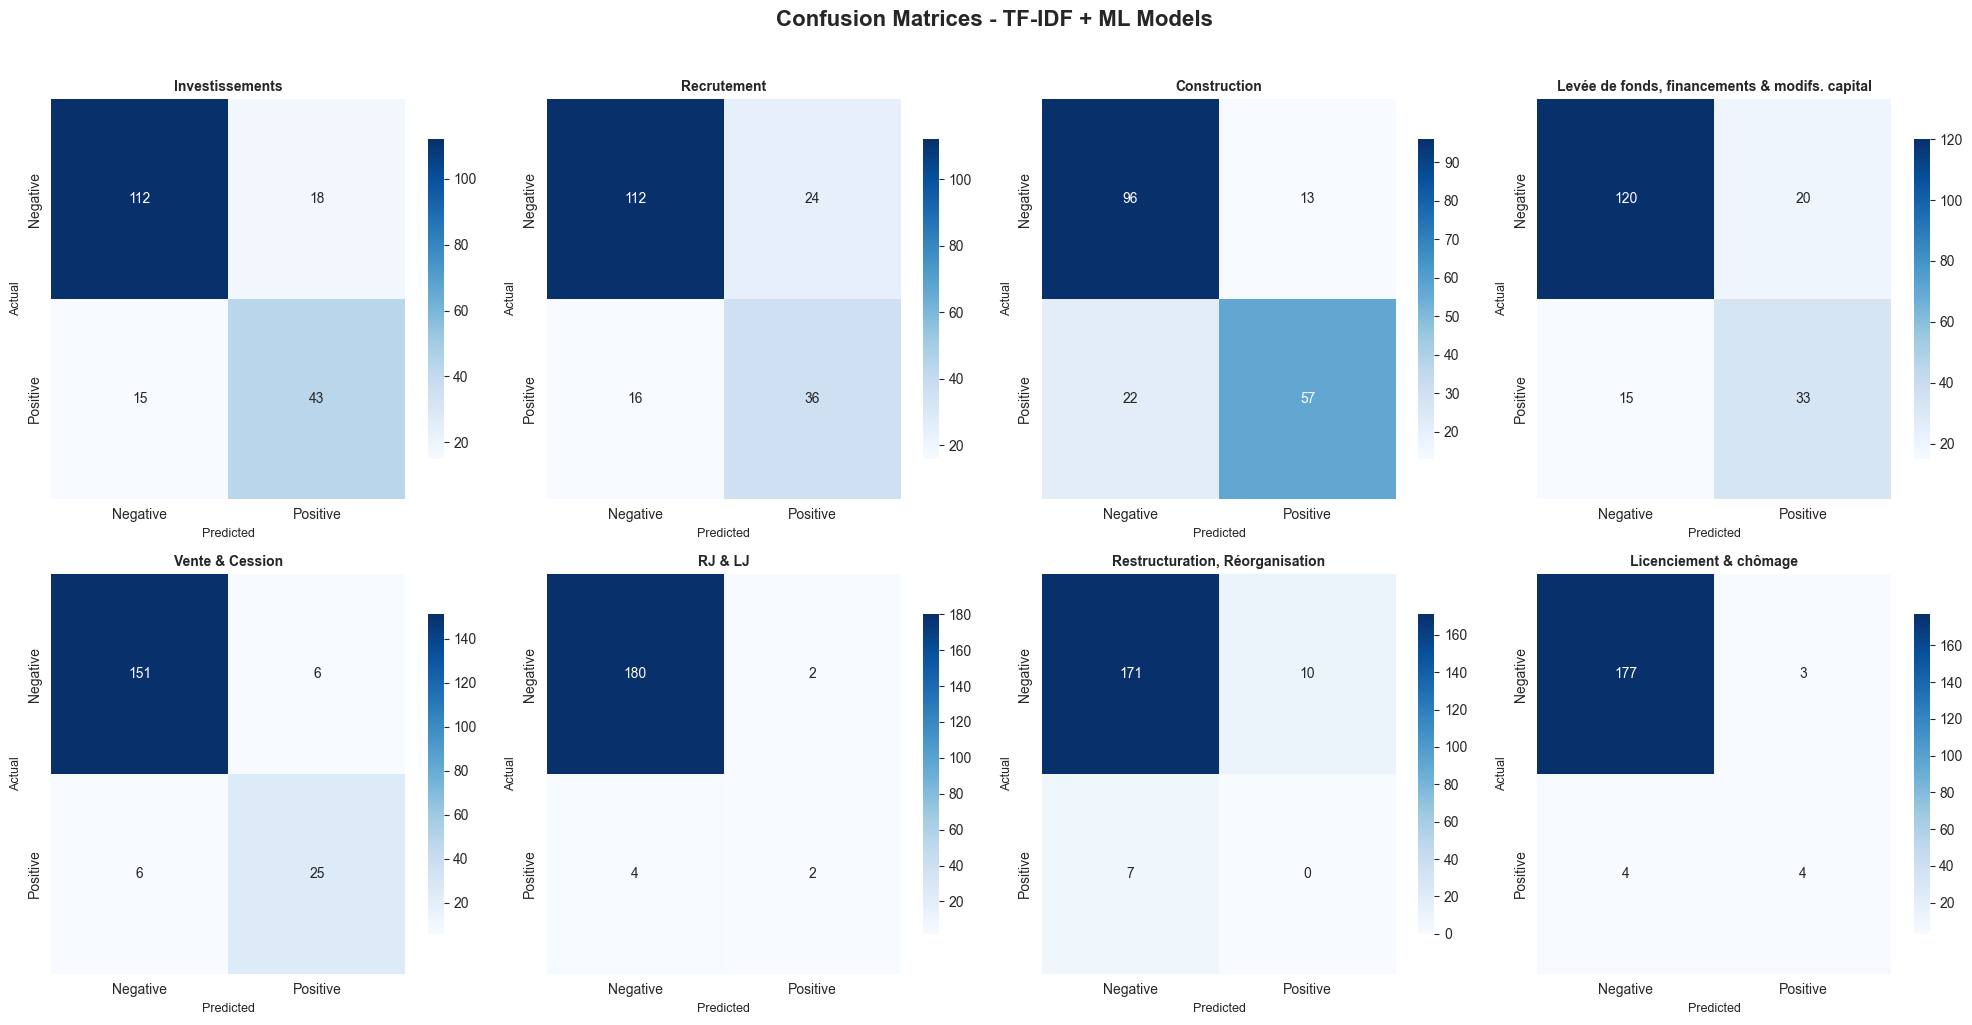

In [24]:
# Plot confusion matrices for all signals
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, signal in enumerate(ALL_SIGNALS):
    cm = confusion_matrix(results[signal]['y_test'], results[signal]['y_pred'])

    # Create heatmap
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=axes[idx],
        cbar_kws={'shrink': 0.8},
        xticklabels=['Negative', 'Positive'],
        yticklabels=['Negative', 'Positive']
    )

    axes[idx].set_title(f'{signal}', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=9)
    axes[idx].set_ylabel('Actual', fontsize=9)

plt.suptitle('Confusion Matrices - TF-IDF + ML Models', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


<!-- ## (9) Generate Article-Level Predictions -->


<!-- ## (12) Optional: Export SHAP Global Importance to CSV -->


In [25]:
# Optional: export global SHAP importance summaries to CSV for further analysis
# Uncomment the lines below if you want to persist the results.

# shap_output_path = Path("../data/tfidf_ml_shap_global_importance.csv")
# shap_output_path.parent.mkdir(parents=True, exist_ok=True)
# df_shap_global_top.to_csv(shap_output_path, index=False)
# shap_output_path


In [26]:
# Generate predictions for all articles using trained models
df_predictions = df_classify[['company_name', 'siren', 'siret', 'title', 'title_processed']].copy()

# Generate predictions for each signal
for signal in ALL_SIGNALS:
    pred_col_name = f"predicted_{get_signal_col_name(signal)}"
    df_predictions[pred_col_name] = results[signal]['model'].predict(
        results[signal]['vectorizer'].transform(df_classify["title_processed"].values)
    )


In [27]:
# Create predicted signal labels list for each article
df_predictions['predicted_signal_labels'] = df_predictions.apply(
    lambda row: [s for s in ALL_SIGNALS if row[f"predicted_{get_signal_col_name(s)}"] == 1],
    axis=1
)

# Count predicted positive and negative signals
df_predictions['predicted_positive_count'] = df_predictions['predicted_signal_labels'].apply(
    lambda x: sum(1 for s in x if s in POSITIVE_SIGNALS) if isinstance(x, list) else 0
)
df_predictions['predicted_negative_count'] = df_predictions['predicted_signal_labels'].apply(
    lambda x: sum(1 for s in x if s in NEGATIVE_SIGNALS) if isinstance(x, list) else 0
)


In [28]:
# Display sample predictions
df_predictions[['company_name', 'title', 'predicted_signal_labels', 'predicted_positive_count', 'predicted_negative_count']].head(10)


,company_name,title,predicted_signal_labels,predicted_positive_count,predicted_negative_count
0,PAIN D'EPICES MULOT ET PETITJEAN,Mulot et Petitjean va injecter 1M€ dans la rénovation de son matériel,[Investissements],1,0
2,PAIN D'EPICES MULOT ET PETITJEAN,Mulot et Petitjean investit 6 M€ et prévoit de recruter 25 personnes,"[Investissements, Recrutement]",2,0
3,PAIN D'EPICES MULOT ET PETITJEAN,Mulot et PetitJean à la conquête de la scène internationale,[Construction],1,0
4,PAIN D'EPICES MULOT ET PETITJEAN,Mulot et Petitjean précise ses projets d'investissements à Dijon,"[Investissements, Construction]",2,0
6,PAIN D'EPICES MULOT ET PETITJEAN,Pains d’épices Mulot et Petitjean investit,[Investissements],1,0
8,PAIN D'EPICES MULOT ET PETITJEAN,Mulot et Petitjean veut s'agrandir,[Construction],1,0
10,PAIN D'EPICES MULOT ET PETITJEAN,Mulot et Petitjean poursuit ses investissements,[Investissements],1,0
11,PAIN D'EPICES MULOT ET PETITJEAN,Des postes à pourvoir chez Mulot et PetitJean,[Recrutement],1,0
12,OROC BAT,Oroc Bat veut s'agrandir,[Construction],1,0
13,OROC BAT,Oroc Bat veut investir au moins 390 k€ dans de nouveaux équipements,"[Investissements, Levée de fonds, financements & modifs. capital]",2,0


<!--  -->

In [29]:
# Prepare output dataframe compatible with business_opportunity_classifier aggregation
df_output = df_predictions[[
    'company_name', 'siren', 'siret', 'title',
    'predicted_signal_labels', 'predicted_positive_count', 'predicted_negative_count'
]].copy()

df_output.sample(5)


,company_name,siren,siret,title,predicted_signal_labels,predicted_positive_count,predicted_negative_count
799,CAFES BIBAL TORREFACTEUR,519017024,51901702400026,"Bibal recrutera, prépare des acquisitions et souhaite s'agrandir","[Recrutement, Construction, Vente & Cession]",2,1
529,ST MICHEL GUINGAMP,431930932,43193093200022,Saint Michel Guingamp prépare l'extension de son site de Saint-Agathon,"[Recrutement, Construction]",2,0
1172,SAS BEYER,947351656,94735165600030,Beyer va recruter et se développer à l'export,"[Recrutement, Levée de fonds, financements & modifs. capital]",2,0
971,COFIGEO,542076633,54207663300131,Cofigeo procède à un LBO ter,[],0,0
1034,SILL ENTREPRISES,636220220,63622022000017,La construction de la nouvelle usine Sill Entreprises se poursuit à Landivisiau ; les recrutemen...,"[Recrutement, Construction]",2,0
